### Assignment Information

| Field | Details |
|-------|---------|
| **Name** | Pros Loung |
| **Course** | AAI-521 Applied Computer Vision for AI |
| **Assignment** | 6.1 - GAN Models |
| **GitHub Repository** | https://github.com/ploung/AAI_521_ComputerVision_Module6.git |


**References:
    - https://www.tensorflow.org/datasets/keras_example


**Part 1- Digit generator**

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
import tensorflow_datasets as tfds

from IPython import display

In [5]:
#a- Reading data
import tensorflow as tf

# Load the mnist dataset from tf.keras
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Print the shape of the training images and labels
print(f"Shape of train_images: {train_images.shape}")
print(f"Type of train_images: {train_images.dtype}")
print(f"Shape of train_labels: {train_labels.shape}")

# Reshape and normalize the images
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Print the new shape of the training images
print(f"\nNew shape of train_images: {train_images.shape}")
print(f"New type of train_images: {train_images.dtype}")

train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1] by deducting 127.5 and dividing to 127.5
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Shape of train_images: (60000, 28, 28)
Type of train_images: uint8
Shape of train_labels: (60000,)

New shape of train_images: (60000, 28, 28, 1)
New type of train_images: float32


In [6]:
# Creating the generative model function
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # 7*7*256 = 12,544 neuros. Input shape is 100-dimensional noise vector
    model.add(layers.BatchNormalization()) # Normalize the activations of the previous layer at each batch
    model.add(layers.LeakyReLU()) # Activation function

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

c:\Users\Loung\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


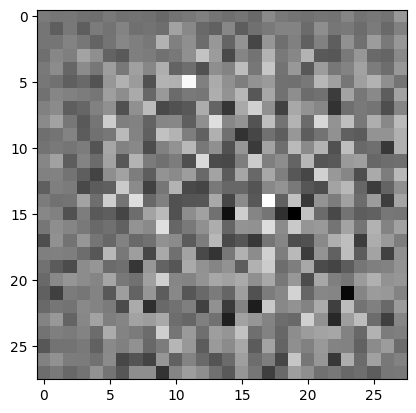

In [7]:
# Use the generator model which is not trained yet to create an image
generator = make_generator_model() # Call the function here

noise = tf.random.normal([1, 100])  #This creates the noise
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [8]:
# Print the shape and values of the noise and generated image
print(f"Noise shape: {noise.shape}")
print(noise[0, :10])  # Print first 10 values of the noise vector
print(f"\nGenerated image shape: {generated_image.shape}")
print(generated_image[0, :, :, 0])  # Print a slice of the generated image

Noise shape: (1, 100)
tf.Tensor(
[-0.70617163 -2.303288    0.00804554  0.65766406  0.5829907  -0.01637366
 -0.74897283 -0.14905055 -1.3065504  -0.16746531], shape=(10,), dtype=float32)

Generated image shape: (1, 28, 28, 1)
tf.Tensor(
[[ 1.29587250e-03 -1.05199299e-03 -5.59672539e-04 -3.76481144e-03
  -5.21604763e-03  7.43262237e-04 -4.01080446e-03 -2.72726174e-03
  -4.51503042e-03 -8.86405632e-03 -2.87012523e-03 -2.99190637e-04
   4.48864745e-03 -2.06396054e-03 -5.35070011e-03 -1.59372529e-03
  -7.80910626e-03  1.00859189e-02  8.35723244e-04 -2.24940106e-03
  -3.36319720e-03 -1.99445710e-03 -3.10740597e-03  7.35094538e-03
  -2.79301824e-03  4.89060767e-05 -2.70618242e-03  1.76661126e-02]
 [-1.82912580e-03 -1.43200792e-02  2.58823857e-05 -1.47101535e-02
   1.31852273e-03 -3.06532276e-03  6.25269627e-03 -4.82290378e-03
  -2.93353619e-03 -5.82865439e-03  2.34378036e-02  8.81427247e-03
  -8.36085808e-03 -1.29865622e-02  8.08811653e-03 -1.50761139e-02
  -4.30556852e-03  1.15827331e-03  5.9

# what is this image?

This is a digital image generated by the untrained generator model from normalized random noise of size (1, 100) created by the tf.random.normal method. The noise is fed into the make_generator_model function which in turns performed up sampling (3x times) and produced a generated grayscale image of size (1, 28, 28, 1).

In [9]:
#c- Create discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
# Applying discriminative model on the untrained image which was the output of generative model
#image_path = "Pros_RRM.jpg"
#image = tf.keras.preprocessing.image.load_img(image_path, color_mode = "grayscale", target_size=(28, 28))
#image = tf.keras.preprocessing.image.img_to_array(image)
#image = (image - 127.5) / 127.5  # Normalize the image to [-1, 1]
#image = np.expand_dims(image, axis=0)  # Add batch dimension

discriminator = make_discriminator_model() # Call discriminator function
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0008708]], shape=(1, 1), dtype=float32)


c:\Users\Loung\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy

<LossFunctionWrapper(<function binary_crossentropy at 0x000002262FC3C360>, kwargs={'from_logits': True, 'label_smoothing': 0.0, 'axis': -1})>

In [12]:
#d- Compute the loss
# Discriminator loss This method quantifies how well the discriminator is able to distinguish real images from fakes.
# It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #Same command as above but for fake_output
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
#Generator loss The generator's loss quantifies how well it was able to trick the discriminator.
#Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
#The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) #same adam optimizer here

In [15]:
# e- Model design
# Let's save the model for future references
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [16]:
# Model parametrs
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
#The training loop begins with generator receiving a random seed as input. That seed is used to produce an image.
#The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator).
#The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    '''
    Arguments:
    images -- real images from the dataset
    '''
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [19]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

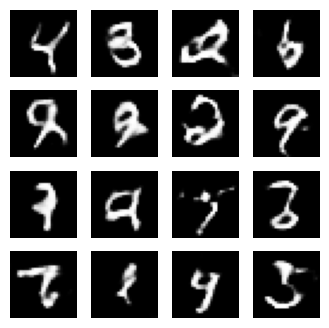

In [23]:
#Call the function in proper way
train(train_dataset, epochs=50)  #Put appropriate values here and call the function


In [22]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

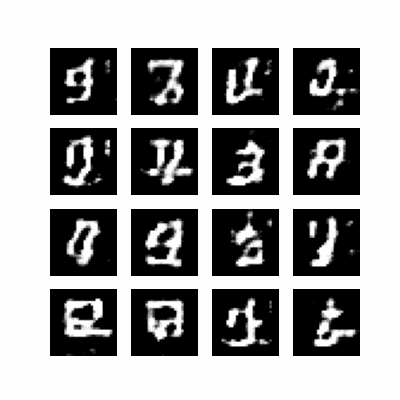

In [6]:
# You can use these commands to save the evpolution as a GIF file
anim_file = 'GAN_digit.gif'

import imageio.v2 as imageio

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

#import IPython.display
#if IPython.version_info > (6,2,0,''):
display.Image(filename=anim_file)

#### what is your understanding from this GIF file?
The codes block above creates an animated GIF from a series of .PNG images resulted from the Generator training process. It shows the evolution of generated digits from the GAN training process. 

- Frame 1-10:   Random noise → Blobby shapes
- Frame 11-30:  Recognizable but distorted digits  
- Frame 31-50:  Clear digits with some artifacts
- Frame 51+:    Clean, realistic MNIST digits

**Part 2- Pokemon characters and GAN**

In [21]:
#Install d2l package
# Uncomment the below line to install d2l package
# !pip install d2l==1.0.0-alpha1.post0

In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [2]:
#a- Read the dataset and store it
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

# We store the directory in this variable
data_dir = d2l.download_extract('pokemon')
batch_size = 256
# Use preprocessing from Keras to read images from directory using given batch size and map them to 64x64 images
pokemon = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size=batch_size, image_size=(64, 64))

Found 40597 files belonging to 721 classes.


In [ ]:
#Normalize the data between [-1,1]
# We normalize the data with  0.5  mean and  0.5  standard deviation to match the value range
# Write a function to normalize the images by dividing them to 255 and use gaussian normalization with mean of 0.5 and standard deviation of 0.5.
def transform_func(X):
    '''
    Write the function here in which it normalied the X in the way explained above.

    ARGUMENTS:
    X -- input image
    '''
    X = X / 255.0
    X = (X - 0.5) / 0.5
    return X

data_iter = pokemon.map(lambda x, y: (transform_func(x), y),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_iter = data_iter.cache().shuffle(buffer_size=1000).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

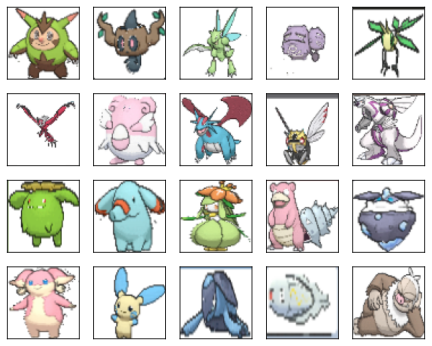

In [ ]:
#b- Visualize first 20 images
d2l.set_figsize(figsize=(4, 4))
for X, y in data_iter.take(1):
    imgs = X[:20, :, :, :] / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)

## The Generator

The generator needs to map the noise variable to a RGB image with width and height to be $64\times 64$ .

In [ ]:
#c- Creating the generator
class G_block(tf.keras.layers.Layer):
    '''
        Creates a generator block with Conv2DTranspose, BatchNormalization, and ReLU activation.

        Arguments:
        out_channels -- number of output channels
        kernel_size -- size of the convolution kernel (default 4)
        strides -- stride of the convolution (default 2)
        padding -- padding type (default "same")
        X -- input image
    '''
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(
            out_channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

#### Explain your understanding of the G_block here.

The G_block class creates a generator block with Conv2DTranspose, BatchNormalization, and ReLU activation. It takes four input arguments: "out_channels", "kernel_size", "strides", and "padding". The out_channels is the number of output maps/filters. The kernel_size is the size of the convolution filter, which defaults to a 4x4 filter. The strides parameter is the upsampling factor - when strides equal 2, it doubles the spatial dimensions. Padding = "same" preserves spatial dimensions after convolution. The output of the Conv2DTranspose layer is then normalized and fed into the activation layer that uses ReLU for non-linearity.
The call method takes in X (input image), upsamples it, normalizes it, and then applies ReLU activation for non-linear transformation.

The G_block is used for upsampling low-resolution images to high-resolution images.

In [ ]:
x = tf.zeros((2, 16, 16, 3))  # Input based on the instruction
#Call the G_block package and use 20 as the number of layers (input of the class)
g_blk = G_block(20)
# Show the dimension of the output
g_blk(x).shape

TensorShape([2, 32, 32, 20])

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.

In [ ]:
n_G = 64
net_G = tf.keras.Sequential([
    # Output: (4, 4, 64 * 8)
    G_block(out_channels=n_G*8, strides=1, padding="valid"),
    G_block(out_channels=n_G*4), # Output: (8, 8, 64 * 4)
    G_block(out_channels=n_G*2), # Output: (16, 16, 64 * 2)
    G_block(out_channels=n_G), # Output: (32, 32, 64)
    # Output: (64, 64, 3)
    tf.keras.layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", use_bias=False,
        activation="tanh")
])

In [ ]:
# Generate a 100 dimensional latent variable to verify the generator's output shape.
x = tf.zeros((1, 1, 1, 100))
net_G(x).shape

TensorShape([1, 64, 64, 3])

## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

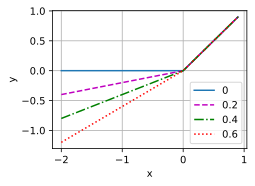

In [ ]:
alphas = [0, .2, .4, .6, .8, 1]
x = tf.range(-2, 1, 0.1)
Y = [tf.keras.layers.LeakyReLU(alpha)(x).numpy() for alpha in alphas]
d2l.plot(x.numpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block

In [ ]:
# d- Block of Discriminator
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

#### Explain your understanding of D_block here.

The code defines a discriminator block for a GAN. It consists of three layers:

- Conv2D: A standard convolutional layer with a 4x4 filter that extracts features and reduces spatial dimensions.
- BatchNormalization: Stabilizes training by normalizing activations.
- LeakyReLU: An activation function that allows small negative values through, as defined by the alpha value.

The class takes the following arguments:
- out_channels: Number of output feature maps/filters
- kernel_size=4: Size of the convolution filter (4x4)
- strides=2: Downsampling factor (halves the spatial dimensions)
- padding="same": Preserves spatial dimensions after convolution
- alpha=0.2: Slope for LeakyReLU's negative side

The call method takes in the input, performs convolution filtering on it to extract features and downsample it, normalizes the output, and then applies the LeakyReLU activation function with a small negative slope.

In [ ]:
x = tf.zeros((2, 16, 16, 3))
#Call the G_block package and use 20 as the number of layers (input of the class)
d_blk = D_block(20)
# Show the dimension of the output
d_blk(x).shape


TensorShape([2, 8, 8, 20])

The discriminator is a mirror of the generator.


In [ ]:
n_D = 64
net_D = tf.keras.Sequential([
    D_block(n_D), # Output: (32, 32, 64)
    D_block(out_channels=n_D*2), # Output: (16, 16, 64 * 2)
    D_block(out_channels=n_D*4), # Output: (8, 8, 64 * 4)
    D_block(out_channels=n_D*8), # Outupt: (4, 4, 64 * 8)
    # Output: (1, 1, 1)
    tf.keras.layers.Conv2D(1, kernel_size=4, use_bias=False)
])

In [ ]:
#It uses a convolution layer with output channel  1  as the last layer to obtain a single prediction value.
x = tf.zeros((1, 64, 64, 3))
net_D(x).shape

TensorShape([1, 1, 1, 1])

## Training




In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    '''
    Trains the GAN model.

    Arguments:
    net_D -- Discriminator network
    net_G -- Generator network
    data_iter -- Data iterator
    num_epochs -- Number of epochs
    lr -- Learning rate
    latent_dim -- Dimension of latent variable
    device -- Device to run the training on (default is GPU if available)
    '''

    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    optimizer_hp = {"learning_rate": lr, "beta_1": 0.5, "beta_2": 0.999} # Changed "lr" to "learning_rate"
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1,
                                 shape=(batch_size, 1, 1, latent_dim))
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        # Show generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat([tf.concat([fake_x[i * 7 + j] for j in range(7)],
                                    axis=1)
                          for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device._device_name)}')

#### Explain your understanding from this model here?

**Note**: When I initially ran the train() function, it failed. To fix this, I updated the optimizer hyperparameter from "lr": lr to "learning_rate": lr.

The codes implement training loop for a GAN. The training pipeline consists of:
1)	Function definition and input arguments:
- net_D:  Discriminator network, it distinguishes real and fake image.
- net_G: Generator network, it creates fake images from random noise. 
- data_iter: It provides real training images.
- Num_epochs: Number training epochs.
- Lr: learning rate for optimizers
- latent_dim: Dimension of the random noise vector (generator input)
2)	Loss function and weight initialization:
- BinaryCrossentroy: It uses Binary Cross Entropy loss for binary classification (real vs fake).
- from_logits=True: The networks output raw logits, no softmax/sigmoid.
- Initializes all weight with normal distribution (mean = 0, stddev = 0.02).
3)	Optimizer Set Up: Set up the optimizer parameters for the discriminator and generator networks with an Adam optimizer. 
4)	Training Loop:
- Outer loop: Iterates through epochs
- Inner loop: Processes each batch of real images X
- Z: Random noise input for generator (batch_size × latent_dim)
- update_D(): Updates discriminator to better distinguish real vs fake
- update_G(): Updates generator to create more convincing fakes
- metric: Tracks discriminator loss, generator loss, and example count
5)	Visualization and Monitoring:
- Generate and display sample images
- Plot losses for the discriminator and generator



loss_D 0.208, loss_G 3.717, 700.0 examples/sec on /GPU:0


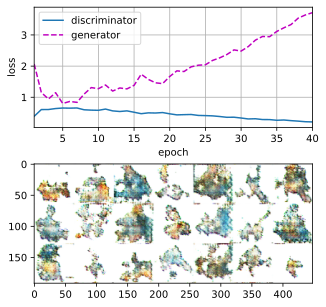

In [ ]:
#We train the model with a small number of epochs just for demonstration. For better performance, the variable num_epochs can be set to a larger number.
latent_dim, lr, num_epochs = 100, 0.0005, 40
train(net_D, net_G, data_iter=data_iter, num_epochs=num_epochs, lr=lr, latent_dim=latent_dim, device=d2l.try_gpu())  #Put proper values here

In [53]:
# what is your understanding from this learning curve?
